<H1>Load Datasets<H1>

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

path = os.getcwd()

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

bracket_training = pd.read_csv(f"{path}/bracket_training.csv", sep= ",")
bracket_training

,CustomerID,CustomerAreaCode,CustomerPostalCode,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,CustomerDMADescription,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion
0,47028,NaN,36093,32.5622,-86.0994,698.0,MONTGOMERY (SELMA),2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694
1,3511,616.0,49464,42.8256,-86.0104,563.0,GRAND RAPIDS - KALMZOO - B. CRK,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164
2,58445,703.0,22210,38.8808,-77.1129,511.0,"WASHINGTON, DC (HAGRSTWN)",2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559
3,28833,NaN,78218,29.4969,-98.4032,641.0,SAN ANTONIO,2023-11-16,3384825,2024-03-21 10:28:56 -0400,311,610,490,559,311,490,490
4,37899,NaN,14212,42.8946,-78.8245,514.0,BUFFALO,2022-03-16,2828017,2024-03-20 20:14:52 -0400,37,457,387,169,457,387,457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129997,70315,720.0,80130,39.5414,-104.9218,751.0,DENVER,2023-05-01,3602437,2024-03-21 11:53:31 -0400,311,457,334,694,311,694,311
129998,51130,832.0,77407,29.6625,-95.7272,618.0,HOUSTON,2024-07-17,2260739,2024-03-19 23:06:28 -0400,311,8,288,694,8,288,288
129999,36902,NaN,89503,39.5354,-119.8374,811.0,RENO,2021-02-20,1298238,2024-03-18 16:17:25 -0400,164,457,288,169,164,288,164
130000,57171,205.0,35244,33.3538,-86.8254,630.0,BIRMINGHAM (ANN & TUSC),2019-06-01,681594,2024-03-17 21:14:21 -0400,164,8,334,559,164,559,559


In [2]:

college_info = pd.read_csv(f'{path}/institutions.csv', sep = ',', encoding= 'utf-8')

#college_info['InstitutionID'].nunique()

college_info_id = college_info.set_index('InstitutionID')

college_info_id
# college_info.sort_index( ascending=True)

,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
InstitutionID,,,,,,,,,,,,,,,,,,,
626,San Diego St.,Aztecs,SDSU,San Diego,CA,92182,825,SAN DIEGO,32.77525,-117.07120,Mountain West Conference,11992,16456,28448,09/01/1947,24,10,9832.94,74.59
402,McNeese,Cowboys,MCNEES,Lake Charles,LA,70609,643,LAKE CHARLES,30.17819,-93.21722,Southland Conference,2245,3462,5707,09/01/1965,30,3,3085.58,80.42
648,South Carolina,Gamecocks,SO CAR,Columbia,SC,29208,546,"COLUMBIA, SC",33.99679,-81.02693,Southeastern Conference,11273,14774,26047,09/01/1936,26,7,11865.45,72.03
175,Dayton,Flyers,DAY,Dayton,OH,45469-1230,542,DAYTON,39.73955,-84.17611,Atlantic 10 Conference,4245,3872,8117,09/01/1951,24,8,9187.23,74.74
317,James Madison,Dukes,JMU,Harrisonburg,VA,22807,569,HARRISONBURG,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35
617,Saint Peter's,Peacocks,STPETE,Jersey City,NJ,07306,501,NEW YORK,40.72710,-74.07154,Metro Atlantic Athletic Conference,697,1095,1792,09/01/1951,19,13,1722.09,65.34
301,Illinois,Fighting Illini,ILL,Champaign,IL,61820,648,CHAMPAIGN & SPRNGFLD - DECATUR,40.10472,-88.22911,Big Ten Conference,17641,15632,33273,09/01/1914,26,8,14438.76,84.41
463,Nebraska,Cornhuskers,NEB,Lincoln,NE,68588,722,LINCOLN & HSTNGS - KRNY,40.81760,-96.70051,Big Ten Conference,9016,9159,18175,09/01/1906,23,10,13178.58,77.58
700,Texas Tech,Red Raiders,TTU,Lubbock,TX,79409,651,LUBBOCK,33.58345,-101.87480,Big 12 Conference,14692,14362,29054,09/01/1937,23,10,10812.85,75.58


<Axes: xlabel='win_%', ylabel='RegularSeasonAverageAttendance'>

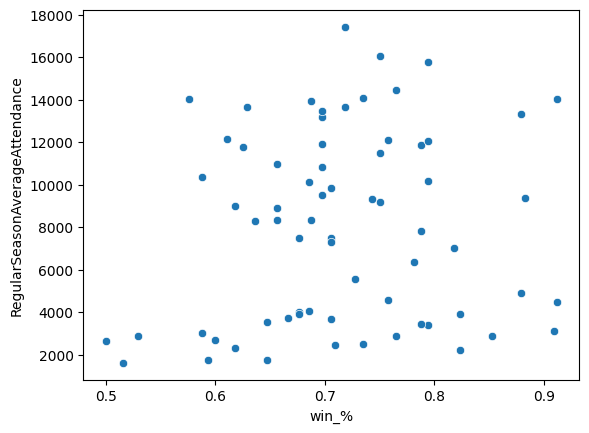

In [3]:

#Slow way to create new columns
# for team in college_info_id['InstitutionName']:
#     college_info_id[f'{team}_win_%'] = college_info_id['RegularSeasonWins']/ (college_info_id['RegularSeasonWins'] + college_info_id['RegularSeasonLosses'])

#Fast way to create new columns
college_info_id['win_%'] = college_info_id['RegularSeasonWins']/ (college_info_id['RegularSeasonWins'] + college_info_id['RegularSeasonLosses'])

#IF college win % isn't causing fans to come to games, will it be the same for customers choosing winners?
sns.scatterplot(x = college_info_id['win_%'], y = college_info_id['RegularSeasonAverageAttendance'])


In [4]:
'''Merge Vs Join'''

# test_df1 = pd.merge(left=bracket_training,
#                     how = "left",
#                     right = college_info_id.add_prefix("EW_"),
#                     left_on = "SemifinalWinner_East_West",
#                     right_index=True,
#                     )

# test_df2 = pd.merge(left= test_df1,
#                     right= college_info_id.add_prefix("SM_"),
#                     how = "left",
#                     left_on = "SemifinalWinner_South_Midwest",
#                     right_index=True
#                     )


test_df = bracket_training.join(
    college_info_id.add_prefix("W_"), on="RegionWinner_West"
).join(
    college_info_id.add_prefix("E_"), on="RegionWinner_East"
).join(
    college_info_id.add_prefix('M_'), on="RegionWinner_Midwest"
).join(
    college_info_id.add_prefix('S_'), on='RegionWinner_South'
)
# print(f'Number of Unique Values: {test_df1['CustomerID'].nunique()}')

test_df


,CustomerID,CustomerAreaCode,CustomerPostalCode,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,CustomerDMADescription,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,W_InstitutionName,W_InstitutionNickname,W_InstitutionAbbreviation,W_InstitutionCity,W_InstitutionState,W_InstitutionPostalCode,W_InstitutionDMACode,W_InstitutionDMADescription,W_InstitutionLatitude,W_InstitutionLongitude,W_InstitutionConference,W_InstitutionEnrollment_Male,W_InstitutionEnrollment_Female,W_InstitutionEnrollment_Total,W_InstitutionNCAAMemberSinceDate,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore,W_win_%,E_InstitutionName,E_InstitutionNickname,E_InstitutionAbbreviation,E_InstitutionCity,E_InstitutionState,E_InstitutionPostalCode,E_InstitutionDMACode,E_InstitutionDMADescription,E_InstitutionLatitude,E_InstitutionLongitude,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Female,E_InstitutionEnrollment_Total,E_InstitutionNCAAMemberSinceDate,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,E_win_%,M_InstitutionName,M_InstitutionNickname,M_InstitutionAbbreviation,M_InstitutionCity,M_InstitutionState,M_InstitutionPostalCode,M_InstitutionDMACode,M_InstitutionDMADescription,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,M_win_%,S_InstitutionName,S_InstitutionNickname,S_InstitutionAbbreviation,S_InstitutionCity,S_InstitutionState,S_InstitutionPostalCode,S_InstitutionDMACode,S_InstitutionDMADescription,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,S_win_%
0,47028,NaN,36093,32.5622,-86.0994,698.0,MONTGOMERY (SELMA),2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694,Arizona,Wildcats,ZONA,Tucson,AZ,85721,789,TUCSON (SIERRA VISTA),32.23267,-110.95080,Pac-12 Conference,13090,17292,30382,09/01/1936,25,8,12118.18,87.94,0.757576,UConn,Huskies,UCONN,Storrs,CT,06269,533,HARTFORD & NEW HAVEN,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,0.911765,Tennessee,Volunteers,TENN,Knoxville,TN,37996,557,KNOXVILLE,35.95208,-83.92585,Southeastern Conference,15269,18536,33805,09/01/1909,24,8,16065.47,79.47,0.750000,James Madison,Dukes,JMU,Harrisonburg,VA,22807,569,HARRISONBURG,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35,0.911765
1,3511,616.0,49464,42.8256,-86.0104,563.0,GRAND RAPIDS - KALMZOO - B. CRK,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,Baylor,Bears,BAY,Waco,TX,76706,625,WACO - TEMPLE - BRYAN,31.54687,-97.12104,Big 12 Conference,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,0.696970,UConn,Huskies,UCONN,Storrs,CT,06269,533,HARTFORD & NEW HAVEN,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,0.911765,Kansas,Jayhawks,KANSAS,Lawrence,KS,66045,616,KANSAS CITY,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,0.687500,Kentucky,Wildcats,UK,Lexington,KY,40506,541,LEXINGTON,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,0.718750
2,58445,703.0,22210,38.8808,-77.1129,511.0,"WASHINGTON, DC (HAGRSTWN)",2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,Baylor,Bears,BAY,Waco,TX,76706,625,WACO - TEMPLE - BRYAN,31.

In [74]:
'''Deleting Unwanted Columns'''

# print(test_df.columns)

classic1_df = test_df[
    [
        'CustomerID',
        #'CustomerAreaCode', 'CustomerPostalCode',
       'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude',
       'CustomerDMACode',
        'CustomerDMADescription',
       'NCAACustomerRecordCreated', 'BracketEntryId',
       'BracketEntryCreatedDate', 'RegionWinner_East', 'RegionWinner_West',
       'RegionWinner_South', 'RegionWinner_Midwest',
       'SemifinalWinner_East_West', 'SemifinalWinner_South_Midwest',
       'NationalChampion',
       'E_InstitutionName',
        # 'E_InstitutionNickname',
        #'E_InstitutionAbbreviation', 'E_InstitutionCity',
        #'E_InstitutionState', 'E_InstitutionPostalCode',
       'E_InstitutionDMACode',
        # 'E_InstitutionDMADescription',
       'E_InstitutionLatitude', 'E_InstitutionLongitude',
       'E_InstitutionConference', 'E_InstitutionEnrollment_Male',
       'E_InstitutionEnrollment_Female', 'E_InstitutionEnrollment_Total',
       'E_InstitutionNCAAMemberSinceDate', 'E_RegularSeasonWins',
       'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance',
       'E_RegularSeasonAverageScore',
       'M_InstitutionName',
        # 'M_InstitutionNickname',
        #'M_InstitutionAbbreviation', 'M_InstitutionCity',
        #'M_InstitutionState', 'M_InstitutionPostalCode',
       'M_InstitutionDMACode',
        # 'M_InstitutionDMADescription',
       'M_InstitutionLatitude', 'M_InstitutionLongitude',
       'M_InstitutionConference', 'M_InstitutionEnrollment_Male',
       'M_InstitutionEnrollment_Female', 'M_InstitutionEnrollment_Total',
       'M_InstitutionNCAAMemberSinceDate', 'M_RegularSeasonWins',
       'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance',
       'M_RegularSeasonAverageScore',
       'S_InstitutionName',
        # 'S_InstitutionNickname',
        #'S_InstitutionAbbreviation', 'S_InstitutionCity',
        #'S_InstitutionState', 'S_InstitutionPostalCode',
       'S_InstitutionDMACode',
        # 'S_InstitutionDMADescription',
       'S_InstitutionLatitude', 'S_InstitutionLongitude',
       'S_InstitutionConference', 'S_InstitutionEnrollment_Male',
       'S_InstitutionEnrollment_Female', 'S_InstitutionEnrollment_Total',
       'S_InstitutionNCAAMemberSinceDate', 'S_RegularSeasonWins',
       'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance',
       'S_RegularSeasonAverageScore',
       'W_InstitutionName',
        #'W_InstitutionNickname', 'W_InstitutionAbbreviation',
        #'W_InstitutionCity', 'W_InstitutionState', 'W_InstitutionPostalCode',
       'W_InstitutionDMACode',
        #'W_InstitutionDMADescription',
       'W_InstitutionLatitude', 'W_InstitutionLongitude',
        #'W_InstitutionConference',
       'W_InstitutionEnrollment_Male',
       'W_InstitutionEnrollment_Female', 'W_InstitutionEnrollment_Total',
       'W_InstitutionNCAAMemberSinceDate', 'W_RegularSeasonWins',
       'W_RegularSeasonLosses', 'W_RegularSeasonAverageAttendance',
       'W_RegularSeasonAverageScore'
    ]
]

classic1_df

,CustomerID,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,CustomerDMADescription,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,E_InstitutionName,E_InstitutionDMACode,E_InstitutionLatitude,E_InstitutionLongitude,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Female,E_InstitutionEnrollment_Total,E_InstitutionNCAAMemberSinceDate,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,M_InstitutionName,M_InstitutionDMACode,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,S_InstitutionName,S_InstitutionDMACode,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,W_InstitutionName,W_InstitutionDMACode,W_InstitutionLatitude,W_InstitutionLongitude,W_InstitutionEnrollment_Male,W_InstitutionEnrollment_Female,W_InstitutionEnrollment_Total,W_InstitutionNCAAMemberSinceDate,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore
0,47028,32.5622,-86.0994,698.0,MONTGOMERY (SELMA),2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Tennessee,557,35.95208,-83.92585,Southeastern Conference,15269,18536,33805,09/01/1909,24,8,16065.47,79.47,James Madison,569,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35,Arizona,789,32.23267,-110.95080,13090,17292,30382,09/01/1936,25,8,12118.18,87.94
1,3511,42.8256,-86.0104,563.0,GRAND RAPIDS - KALMZOO - B. CRK,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Kansas,616,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,Kentucky,541,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,Baylor,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55
2,58445,38.8808,-77.1129,511.0,"WASHINGTON, DC (HAGRSTWN)",2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,Houston,618,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03,Baylor,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55
3,28833,29.4969,-98.4032,641.0,SAN ANTONIO,2023-11-16,3384825,2024-03-21 10:28:56 -0400,311,610,490,559,311,490,490,Iowa St.,679,42.02621,-93.64851,Big 12 Conference,14070,11171,25241,09/01/1908,27,7,12059.44,75.56,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,NC State,560,35.78511,-78.67451,Atlantic Coast Conference,11649,11794,23443,09/01/1941,22,14,12147.11,76.36,Saint Mary's,807,37.84073,-122.10900,859,1090,1949,09/01/1961,26,7,3458.15,74.24
4,37899,42.8946,-78.8245,514.0,BUFFALO,2022-03-16,2828017,2024-03-20 20:14:52 -0400,37,457,387,169,457,387,457,Auburn,522,32.59938,-85.48826,Southeastern Conference,12695,12684,25379,09/01/1910,27,7,10182.91,83.32,Creighton,652,41.26536,-95.94781,Big East Conference,1789,2501,4290,09/01/1923,23,9,13651.44,80.53,Marquette,617,43.03903,-87.92796,B

In [79]:
'''Checking NAs'''

#Since the Nan values surmount to around 0.5% of the sample size, I am choosing to get rid of them
# for column in classic1_df.columns:
#     print(f'{column}: {round(((classic1_df[column].isna().sum())/classic1_df.shape[0]) * 100, 3)}  %Nan Values')

classic1_no_na = classic1_df.dropna(axis = 0)

#As We can see the bracket_entry_id is the Number of rows in the dataset, therefore its the primary key
#Also Important, Unique Values is 76097, meaning there are 76097 unique customers that created brackets in 2024
for column in classic1_df.columns:
    print(f'{column}: {((classic1_df[column].nunique()))}  Unique Values')

CustomerID: 76097  Unique Values
CustomerPostalCodeLatitude: 14083  Unique Values
CustomerPostalCodeLongitude: 14540  Unique Values
CustomerDMACode: 209  Unique Values
CustomerDMADescription: 209  Unique Values
NCAACustomerRecordCreated: 3226  Unique Values
BracketEntryId: 130002  Unique Values
BracketEntryCreatedDate: 100468  Unique Values
RegionWinner_East: 16  Unique Values
RegionWinner_West: 16  Unique Values
RegionWinner_South: 16  Unique Values
RegionWinner_Midwest: 16  Unique Values
SemifinalWinner_East_West: 32  Unique Values
SemifinalWinner_South_Midwest: 32  Unique Values
NationalChampion: 64  Unique Values
E_InstitutionName: 16  Unique Values
E_InstitutionDMACode: 14  Unique Values
E_InstitutionLatitude: 16  Unique Values
E_InstitutionLongitude: 16  Unique Values
E_InstitutionConference: 13  Unique Values
E_InstitutionEnrollment_Male: 16  Unique Values
E_InstitutionEnrollment_Female: 16  Unique Values
E_InstitutionEnrollment_Total: 16  Unique Values
E_InstitutionNCAAMemberSi

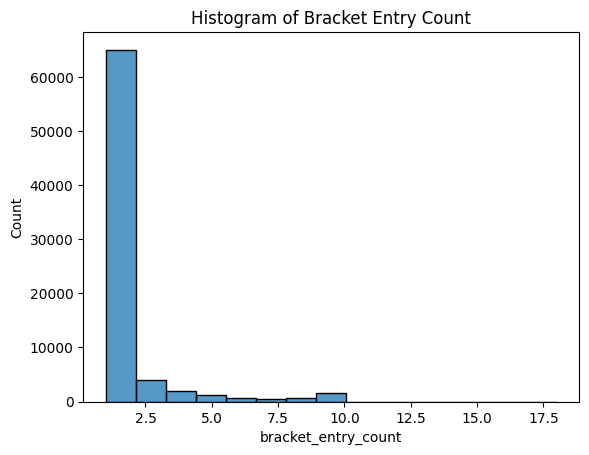

In [80]:
num_brackets_df = classic1_no_na.groupby(by = 'CustomerID').agg(bracket_entry_count= pd.NamedAgg(column = "BracketEntryId", aggfunc = 'count'))

#Way to get agg function to apply to bracket entry id 
# {'BracketEntryId': 'count'}
num_brackets_df[num_brackets_df['bracket_entry_count'] > 1]

# perc_Id_w_multiple_brackets = num_brackets_df[num_brackets_df['BracketEntryId'] > 1].shape[0] / num_brackets_df.shape[0]

# print(perc_Id_w_multiple_brackets)

#We can see that the majority of customers have bracket entries of 1-4
ax = sns.histplot(num_brackets_df['bracket_entry_count'], bins=15)
ax.set_title('Histogram of Bracket Entry Count')
plt.show()




In [82]:
classic2_df = classic1_no_na.join(num_brackets_df,
                               on= 'CustomerID',
                               how = 'left'                         
)

classic2_df

# for column in classic2_df.columns:
#     print(f'{column}: {round(((classic2_df[column].isna().sum())/classic2_df.shape[0]) * 100, 3)}  %Nan Values')

,CustomerID,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,CustomerDMADescription,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,E_InstitutionName,E_InstitutionDMACode,E_InstitutionLatitude,E_InstitutionLongitude,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Female,E_InstitutionEnrollment_Total,E_InstitutionNCAAMemberSinceDate,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,M_InstitutionName,M_InstitutionDMACode,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,S_InstitutionName,S_InstitutionDMACode,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,W_InstitutionName,W_InstitutionDMACode,W_InstitutionLatitude,W_InstitutionLongitude,W_InstitutionEnrollment_Male,W_InstitutionEnrollment_Female,W_InstitutionEnrollment_Total,W_InstitutionNCAAMemberSinceDate,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore,bracket_entry_count
0,47028,32.5622,-86.0994,698.0,MONTGOMERY (SELMA),2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Tennessee,557,35.95208,-83.92585,Southeastern Conference,15269,18536,33805,09/01/1909,24,8,16065.47,79.47,James Madison,569,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35,Arizona,789,32.23267,-110.95080,13090,17292,30382,09/01/1936,25,8,12118.18,87.94,8
1,3511,42.8256,-86.0104,563.0,GRAND RAPIDS - KALMZOO - B. CRK,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Kansas,616,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,Kentucky,541,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,Baylor,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,1
2,58445,38.8808,-77.1129,511.0,"WASHINGTON, DC (HAGRSTWN)",2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,Houston,618,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03,Baylor,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,2
3,28833,29.4969,-98.4032,641.0,SAN ANTONIO,2023-11-16,3384825,2024-03-21 10:28:56 -0400,311,610,490,559,311,490,490,Iowa St.,679,42.02621,-93.64851,Big 12 Conference,14070,11171,25241,09/01/1908,27,7,12059.44,75.56,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,NC State,560,35.78511,-78.67451,Atlantic Coast Conference,11649,11794,23443,09/01/1941,22,14,12147.11,76.36,Saint Mary's,807,37.84073,-122.10900,859,1090,1949,09/01/1961,26,7,3458.15,74.24,8
4,37899,42.8946,-78.8245,514.0,BUFFALO,2022-03-16,2828017,2024-03-20 20:14:52 -0400,37,457,387,169,457,387,457,Auburn,522,32.59938,-85.48826,Southeastern Conference,12695,12684,25379,09/01/1910,27,7,10182.91,83.32,Creighton,652,41.26536,-95.94781,Big East Conference,1789,2501,4290,09/01/1923,23,9,13651.44,80.53,Marque

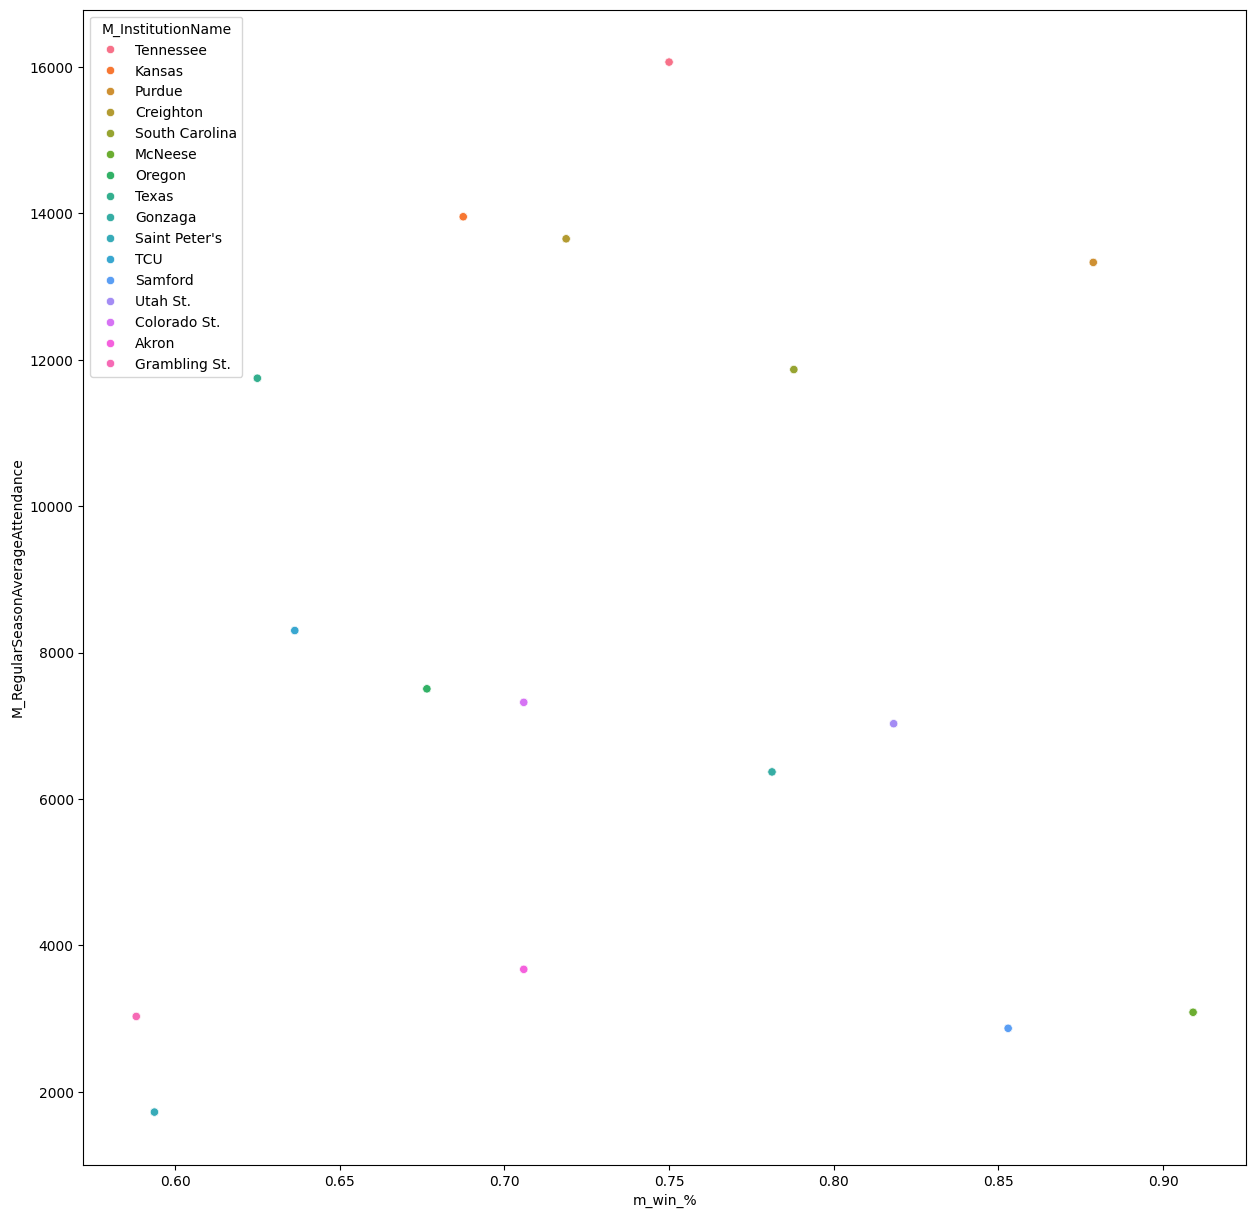

In [9]:
classic2_df['m_win_%'] = classic2_df['M_RegularSeasonWins']/ (classic2_df['M_RegularSeasonWins'] + classic2_df['M_RegularSeasonLosses'])
classic2_df['s_win_%'] = classic2_df['S_RegularSeasonWins']/ (classic2_df['S_RegularSeasonWins'] + classic2_df['S_RegularSeasonLosses'])
classic2_df['e_win_%'] = classic2_df['E_RegularSeasonWins']/ (classic2_df['E_RegularSeasonWins'] + classic2_df['E_RegularSeasonLosses'])
classic2_df['w_win_%'] = classic2_df['W_RegularSeasonWins']/ (classic2_df['W_RegularSeasonWins'] + classic2_df['W_RegularSeasonLosses'])


#Sample graph to show that Customers do not care about How much their team wins!
plt.figure(figsize=(15,15))
ax_attendance = sns.scatterplot(x = classic2_df['m_win_%'], y = classic2_df['M_RegularSeasonAverageAttendance'], hue=classic2_df['M_InstitutionName'])
plt.show()


In [10]:
# #76097 Customer Ids and It seems that 445 customers created multiple brackets
# #76097 - 75652 = 445

# #We will not be using this transformation any way!
# seq_df = classic2_df.groupby("CustomerID").agg({
#     "RegionWinner_East": lambda x: list(x),
#     "RegionWinner_West": lambda x: list(x),
#     "RegionWinner_South": lambda x: list(x),
#     "RegionWinner_Midwest": lambda x: list(x),
# })
# seq_df

In [11]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

#Baseline Model -- Choose Team with Higher Winning Percentage

#Create Dataset including information on Midwest Team and South Team

mid_south_basic_df = classic2_df.loc[:, ["RegionWinner_South", 'RegionWinner_Midwest', 'm_win_%','s_win_%', 'SemifinalWinner_South_Midwest']]

X_sm = mid_south_basic_df.drop(columns = ['SemifinalWinner_South_Midwest'])
Y_sm = mid_south_basic_df['SemifinalWinner_South_Midwest']

#Predict that the User will choose the team with higer win %
X_sm['Predicted Winner Binary'] =  (X_sm['m_win_%'] > X_sm['s_win_%']).astype(int)
X_sm['Predicted Winner'] =  np.where(X_sm['Predicted Winner Binary'] == 1, X_sm['RegionWinner_Midwest'], X_sm['RegionWinner_South'])
X_sm['Actual Winner'] = (mid_south_basic_df['SemifinalWinner_South_Midwest'] == X_sm['RegionWinner_Midwest']).astype(int)


recall = recall_score(X_sm['Actual Winner'], X_sm['Predicted Winner Binary'])
accuracy = accuracy_score(X_sm['Actual Winner'], X_sm['Predicted Winner Binary'])

print(f'Baseline Model: Recall {recall}, Accuracy {accuracy}')



east_west_basic_df = classic2_df.loc[:, ["RegionWinner_East", 'RegionWinner_West', 'e_win_%','w_win_%', 'SemifinalWinner_East_West']]

X2_sm = east_west_basic_df.drop(columns = ['SemifinalWinner_East_West'])
Y2_sm = east_west_basic_df['SemifinalWinner_East_West']

#Predict that the User will choose the team with higher win %
X2_sm['Predicted Winner Binary'] =  (X2_sm['e_win_%'] > X2_sm['w_win_%']).astype(int) #IF east wins then 1, else 0
X2_sm['Predicted Winner'] =  np.where(X2_sm['Predicted Winner Binary'] == 1, X2_sm['RegionWinner_East'], X2_sm['RegionWinner_West'])
X2_sm['Actual Winner'] = (east_west_basic_df['SemifinalWinner_East_West'] == X2_sm['RegionWinner_East']).astype(int)


recall2 = recall_score(X2_sm['Actual Winner'], X2_sm['Predicted Winner Binary'])
accuracy2 = accuracy_score(X2_sm['Actual Winner'], X2_sm['Predicted Winner Binary'])

print(f'Baseline Model: Recall {recall2}, Accuracy {accuracy2}')


nat_champ_basic_df = nat_champ_basic_df = pd.DataFrame({
    "ew_pred_win_%": east_west_basic_df["e_win_%"].where(X2_sm["Predicted Winner Binary"] == 1, east_west_basic_df["w_win_%"]),
    "ms_pred_win_%": mid_south_basic_df["m_win_%"].where(X_sm["Predicted Winner Binary"] == 1, mid_south_basic_df["s_win_%"]),
    "actual_nat_champ": classic2_df['NationalChampion']  # Example actual champions
})

# Predict the national champion based on the higher winning percentage
nat_champ_basic_df["predict_nat_champ_binary"] = (
    nat_champ_basic_df["ew_pred_win_%"] > nat_champ_basic_df["ms_pred_win_%"]
).astype(int)

nat_champ_basic_df["actual_nat_champ_binary"] = (nat_champ_basic_df["actual_nat_champ"] == X2_sm["Predicted Winner"]).astype(int) #IF Pred Winner is East West

# Calculate accuracy and recall for national champion prediction
recall_nat_champ = recall_score(nat_champ_basic_df["actual_nat_champ_binary"], nat_champ_basic_df["predict_nat_champ_binary"])
accuracy_nat_champ = accuracy_score(nat_champ_basic_df["actual_nat_champ_binary"], nat_champ_basic_df["predict_nat_champ_binary"])

# Display results
print(f'National Champion Prediction - Baseline Model: Recall {recall_nat_champ:.2f}, Accuracy {accuracy_nat_champ:.2f}')

# X_train, X_test, y_train, y_test = train_test_split(X_sm, Y_sm, test_size=.2, random_state=24)

# log_reg_sm = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
# log_reg_sm.fit(X_train, y_train)


Baseline Model: Recall 0.5000532897541566, Accuracy 0.5993390809045459
Baseline Model: Recall 0.8869589698394046, Accuracy 0.6550760753478725
National Champion Prediction - Baseline Model: Recall 0.83, Accuracy 0.52


In [12]:
#Creation of Model 1

#Features:
#Team Win % Differential: (Team 1 % - Team 2 %) --> Negative for team 1, Positive for Team 2
#Closeness of Team: eclidean distance between both teams --> if lower distance has greater predictive power on team choice,
#                                                                                    then then customer prefers closer team
#Sentiment of Team: Teams with higher Sentiment Score will have more people choosing them to win




'''Closeness Metric ~ Takes Two Haversine Distances:

#1.) Find Haversine Distance to convert cartestian cordinates (x,y) for polar coordinates (They Coordinates that take into account the spherical shape of the earth)
#2.) Haversine Distance 1 -> How far the user is from Team 1
#3.) Haversine Distance 2 -> How far the user is from Team 2
#4.)Closeness = Haversine Distance 1 - Haversine Distance 2
#5.) This number shows us: If Negative that user is closer to team 2, If Positive user is closer to team 1, If 0 then Teams are same distance away!
'''
def closeness(userlat:float , userlon: float, team1lat:float , team1lon:float, team2lat:float, team2lon: float) -> float:

    #Calculates Haversine Distance
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371  # Earth's radius in km
        
        # Convert degrees to radians
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        
        # Compute differences
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1
        
        # Haversine formula
        a = np.sin(delta_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        
        return R * c
    #Calculate Distance for Both Teams
    d1 = haversine_distance(userlat, userlon, team1lat, team1lon)
    d2 = haversine_distance(userlat, userlon, team2lat, team2lon)
    
    return d1 - d2

model_1_df = classic2_df
model_1_df['closeness_ms'] = closeness(userlat=classic2_df['CustomerPostalCodeLatitude'],
                                      userlon=classic2_df['CustomerPostalCodeLongitude'],
                                      team1lat=classic2_df['M_InstitutionLatitude'],
                                      team1lon=classic2_df['M_InstitutionLongitude'],
                                      team2lat=classic2_df['S_InstitutionLatitude'],
                                      team2lon=classic2_df['S_InstitutionLongitude'])


model_1_df['closeness_ew'] = closeness(userlat=classic2_df['CustomerPostalCodeLatitude'],
                                      userlon=classic2_df['CustomerPostalCodeLongitude'],
                                      team1lat=classic2_df['E_InstitutionLatitude'],
                                      team1lon=classic2_df['E_InstitutionLongitude'],
                                      team2lat=classic2_df['W_InstitutionLatitude'],
                                      team2lon=classic2_df['W_InstitutionLongitude'])


'''Finding Team Win % Differential'''
model_1_df['team_win_diff_ms'] = model_1_df['m_win_%'] - model_1_df['s_win_%']
model_1_df['team_win_diff_ew'] = model_1_df['e_win_%'] - model_1_df['w_win_%']


X_model_1_ms = model_1_df.loc[:, ['team_win_diff_ms', 'closeness_ms']]
y_model_1_ms = (model_1_df['SemifinalWinner_South_Midwest'] == model_1_df['RegionWinner_Midwest']).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_model_1_ms, y_model_1_ms, train_size=.2, random_state= 24)

log_reg_sm = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
log_reg_sm.fit(X_train, y_train)
log_reg_sm.coef_

array([[ 3.52227933e+00, -1.55073838e-04]])

In [ ]:
log_reg_sm.coef_


TypeError: missing a required argument: 'y_true'

In [14]:

y_pred = log_reg_sm.predict(X_test)

# Compute recall
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Recall on Test Data: {recall:.4f}")
print(f'Model Accuracy on Test Data: {accuracy:.4f}')

Model Recall on Test Data: 0.3278
Model Accuracy on Test Data: 0.6077


In [ ]:

X_model_1_ew = model_1_df.loc[:, ['team_win_diff_ew', 'closeness_ew']]
y_model_1_ew = (model_1_df['SemifinalWinner_East_West'] == model_1_df['RegionWinner_East']).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_model_1_ew, y_model_1_ew, train_size=.2, random_state= 24)

log_reg_ew = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
log_reg_ew.fit(X_train, y_train)
log_reg_ew.coef_

array([[ 1.89993871e-02, -6.68585823e-05]])

In [16]:
y_pred = log_reg_ew.predict(X_test)

# Compute recall
recall_ew = recall_score(y_test, y_pred)
accuracy_ew = accuracy_score(y_test, y_pred)

print(f"Model Recall on Test Data: {recall_ew:.4f}")
print(f'Model Accuracy on Test Data: {accuracy_ew:.4f}')

Model Recall on Test Data: 1.0000
Model Accuracy on Test Data: 0.6324


In [17]:
nat_champ_model_1_df = nat_champ_basic_df = pd.DataFrame({
    "ew_pred_win_%": model_1_df["e_win_%"].where(y_model_1_ew == 1, model_1_df["w_win_%"]), #Return The Win Percentage of the winning team 1 = East, 0 = West
    "ms_pred_win_%": model_1_df["m_win_%"].where(y_model_1_ms == 1, model_1_df["s_win_%"]), #Return The Win Percentage of the winning team 1 = Midwest, 0 = South
    'ew_lat': classic2_df['E_InstitutionLatitude'].where(y_model_1_ew == 1, classic2_df['W_InstitutionLatitude']),
    'ew_lon':classic2_df['E_InstitutionLongitude'].where(y_model_1_ew == 1, classic2_df['W_InstitutionLongitude']),
    'ms_lat': classic2_df['M_InstitutionLatitude'].where(y_model_1_ms == 1, classic2_df['S_InstitutionLatitude']),
    'ms_lon': classic2_df['M_InstitutionLongitude'].where(y_model_1_ms == 1, classic2_df['S_InstitutionLongitude']),
    "actual_nat_champ": (classic2_df['NationalChampion'] == classic2_df["SemifinalWinner_East_West"]).astype(int)  # Create a Binary column where 1 = EW Champ, 0 = SM Champ
})



nat_champ_model_1_df['team_win_diff_nat'] =  nat_champ_model_1_df['ew_pred_win_%'] - nat_champ_model_1_df['ms_pred_win_%']


nat_champ_model_1_df['closeness_nat'] = closeness(userlat=classic2_df['CustomerPostalCodeLatitude'],
                                userlon=classic2_df['CustomerPostalCodeLongitude'],
                                team1lat= nat_champ_model_1_df['ew_lat'],
                                team1lon = nat_champ_model_1_df['ew_lon'],
                                team2lat= nat_champ_model_1_df['ms_lat'],
                                team2lon= nat_champ_model_1_df['ms_lon'])

# nat_champ_model_1_df

X_model_1_nat = nat_champ_model_1_df.loc[:, ['team_win_diff_nat','closeness_nat']]
y_model_1_nat = nat_champ_model_1_df['actual_nat_champ']

X_train, X_test, y_train, y_test = train_test_split(X_model_1_nat, y_model_1_nat, train_size=.2, random_state=24)

log_reg_nat = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
log_reg_nat.fit(X_train, y_train)



LogisticRegressionCV(cv=5, n_jobs=-1, random_state=24, refit=False,
                     scoring='recall')

In [18]:
recall_nat = recall_score(y_test, y_pred)
accuracy_nat = accuracy_score(y_test, y_pred)

print(f"Model Recall on Test Data: {recall_nat:.4f}")
print(f'Model Accuracy on Test Data: {accuracy_nat:.4f}')

Model Recall on Test Data: 1.0000
Model Accuracy on Test Data: 0.5695


In [ ]:
'''Questions:

I believe that there might have been a couple of mistakes while assigning the winners of each round in my model. 

I created a logistic regression 3 times for 3 rounds of the Marchmadness bracket, every bracket corresponds to a bracket that was created by a customer. 

I want to ensure that while assigning the winners within each bracket that it is correctly assigned.

Key pieces of code to evaluate: 

Did I assign the Winner of the East as 1 and Winner of West as 0?

Code: 

X_model_1_ew = model_1_df.loc[:, ['team_win_diff_ew', 'closeness_ew']]
y_model_1_ew = (model_1_df['SemifinalWinner_East_West'] == model_1_df['RegionWinner_East']).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_model_1_ew, y_model_1_ew, train_size=.2, random_state= 24)

log_reg_ew = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
log_reg_ew.fit(X_train, y_train)
log_reg_ew.coef_

Next Question: 

Did I assign the Winner of Midwest vs South Semifinals as 1 = Midwest and 0 = South?

Code:

model_1_df = classic2_df
model_1_df['closeness_ms'] = closeness(userlat=classic2_df['CustomerPostalCodeLatitude'],
                                      userlon=classic2_df['CustomerPostalCodeLongitude'],
                                      team1lat=classic2_df['M_InstitutionLatitude'],
                                      team1lon=classic2_df['M_InstitutionLongitude'],
                                      team2lat=classic2_df['S_InstitutionLatitude'],
                                      team2lon=classic2_df['S_InstitutionLongitude'])

model_1_df['closeness_ew'] = closeness(userlat=classic2_df['CustomerPostalCodeLatitude'],
                                      userlon=classic2_df['CustomerPostalCodeLongitude'],
                                      team1lat=classic2_df['E_InstitutionLatitude'],

Did I assign East_West Winner = 1 and  South_Midwest Winner = 0?

Was logic correct to accurately train data? 

Code: 
nat_champ_model_1_df = nat_champ_basic_df = pd.DataFrame({
    "ew_pred_win_%": model_1_df["e_win_%"].where(y_model_1_ew == 1, model_1_df["w_win_%"]), #Return The Win Percentage of the winning team 1 = East, 0 = West
    "ms_pred_win_%": model_1_df["m_win_%"].where(y_model_1_ms == 1, model_1_df["s_win_%"]), #Return The Win Percentage of the winning team 1 = Midwest, 0 = South
    'ew_lat': classic2_df['E_InstitutionLatitude'].where(y_model_1_ew == 1, classic2_df['W_InstitutionLatitude']),
    'ew_lon':classic2_df['E_InstitutionLongitude'].where(y_model_1_ew == 1, classic2_df['W_InstitutionLongitude']),
    'ms_lat': classic2_df['M_InstitutionLatitude'].where(y_model_1_ms == 1, classic2_df['S_InstitutionLatitude']),
    'ms_lon': classic2_df['M_InstitutionLongitude'].where(y_model_1_ms == 1, classic2_df['S_InstitutionLongitude']),
    "actual_nat_champ": (classic2_df['NationalChampion'] == classic2_df["SemifinalWinner_East_West"]).astype(int)  # Create a Binary column where 1 = EW Champ, 0 = SM Champ
})

nat_champ_model_1_df['team_win_diff_nat'] =  nat_champ_model_1_df['ew_pred_win_%'] - nat_champ_model_1_df['ms_pred_win_%']

nat_champ_model_1_df['closeness_nat'] = closeness(userlat=classic2_df['CustomerPostalCodeLatitude'],
                                userlon=classic2_df['CustomerPostalCodeLongitude'],
                                team1lat= nat_champ_model_1_df['ew_lat'],
                                team1lon = nat_champ_model_1_df['ew_lon'],
                                team2lat= nat_champ_model_1_df['ms_lat'],
                                team2lon= nat_champ_model_1_df['ms_lon'])

# nat_champ_model_1_df

X_model_1_nat = nat_champ_model_1_df.loc[:, ['team_win_diff_nat','closeness_nat']]
y_model_1_nat = nat_champ_model_1_df['actual_nat_champ']

X_train, X_test, y_train, y_test = train_test_split(X_model_1_nat, y_model_1_nat, train_size=.2, random_state=24)

log_reg_nat = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
log_reg_nat.fit(X_train, y_train)
'''

SyntaxError: invalid syntax (45017901.py, line 1)

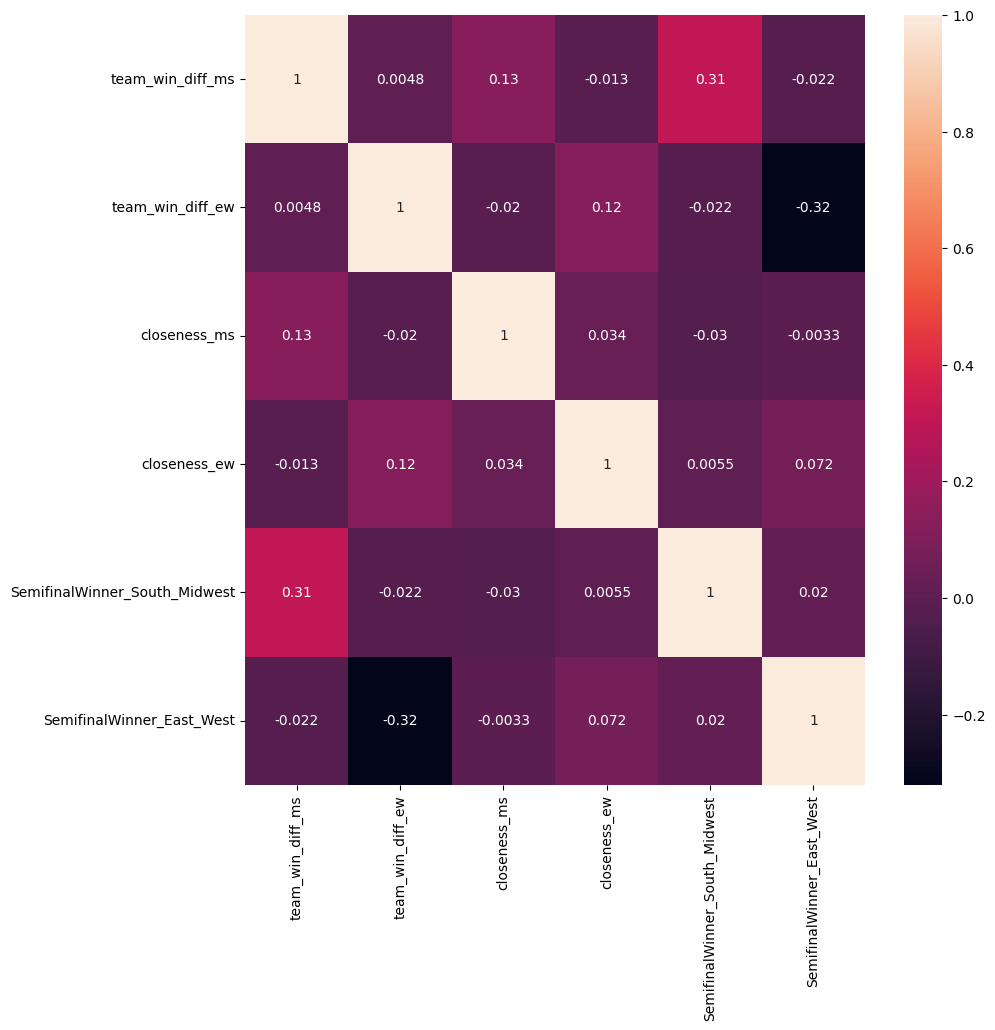

In [19]:
'''Evaluation of Metrics'''
# %pip install openpyxl
corr = model_1_df.loc[:, ['team_win_diff_ms','team_win_diff_ew','closeness_ms', 'closeness_ew','SemifinalWinner_South_Midwest', 'SemifinalWinner_East_West']].corr()

# corr.to_excel('~/Desktop/output.xlsx', index=False)

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)
plt.show()


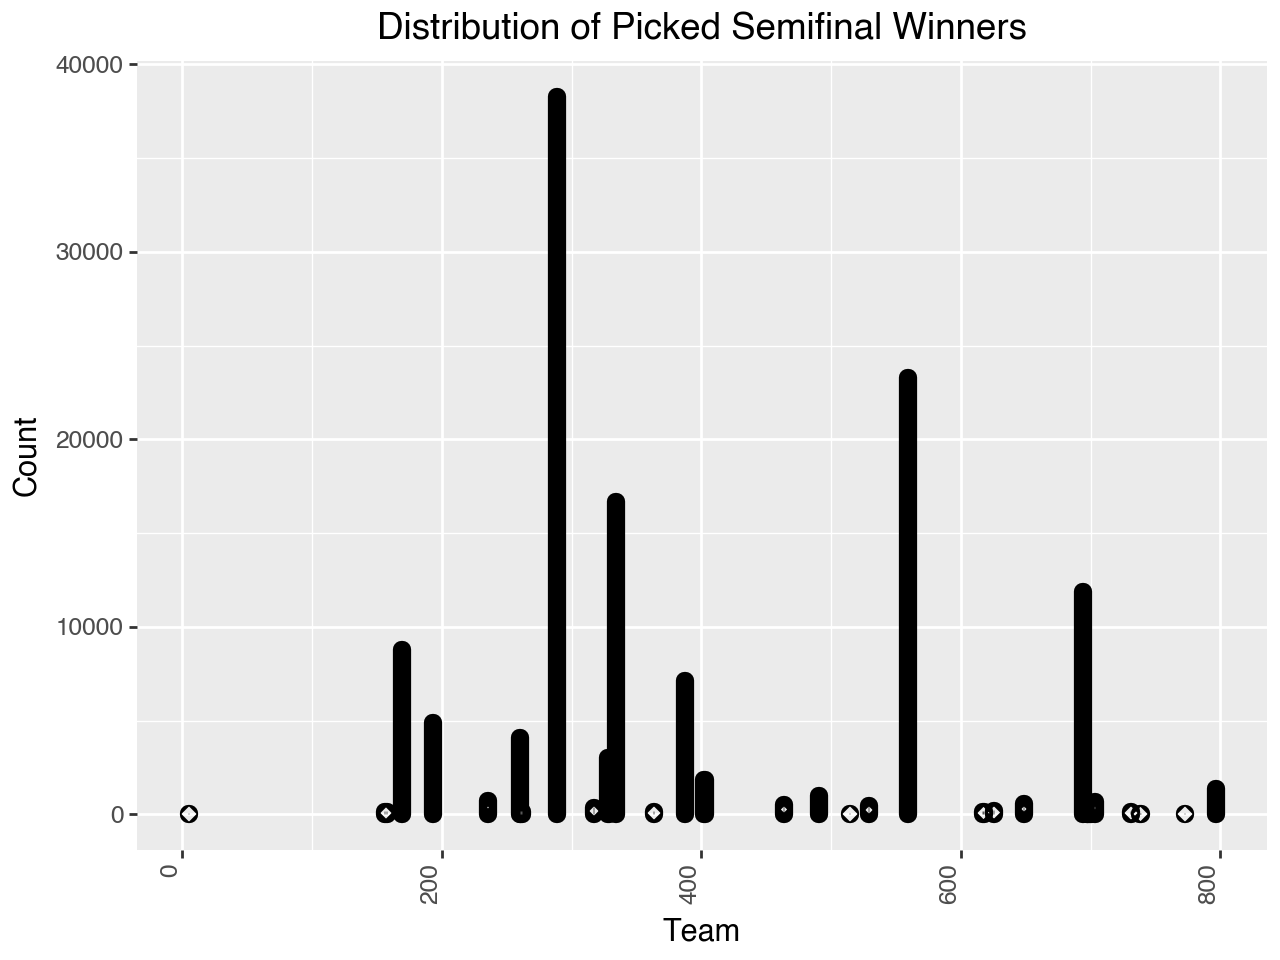

In [30]:
# sns.scatterplot(x=model_1_df['team_win_diff_ms'], y=model_1_df['SemifinalWinner_South_Midwest'])




from plotnine import ggplot, aes, geom_bar, labs, theme, element_text

p = (
    ggplot(model_1_df, aes(x='SemifinalWinner_South_Midwest'))
    + geom_bar(color='black', size = 3.5)
    + labs(x='Team', y='Count', title='Distribution of Picked Semifinal Winners')
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
)

p

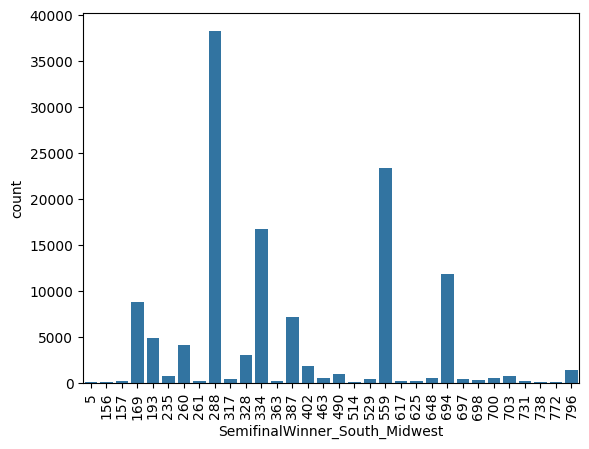

In [57]:
ax_1 = ax_1 = sns.countplot(x=model_1_df['SemifinalWinner_South_Midwest'])
plt.xticks(rotation=90)
plt.show()

In [36]:
college_info[college_info['InstitutionID'] == 288]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
14,288,Houston,Cougars,HOU,Houston,TX,77204,618,HOUSTON,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03


In [62]:
top_picks = college_info[(college_info["InstitutionID"] == 559) |
             (college_info["InstitutionID"] == 334) |
             (college_info["InstitutionID"] == 387) |
             (college_info["InstitutionID"] == 694) |
             (college_info['InstitutionID'] == 169) |
             (college_info["InstitutionID"] == 288)].sort_values('RegularSeasonWins', ascending=False)
top_picks.loc[:, ['InstitutionID', 'InstitutionName', 'InstitutionDMACode','RegularSeasonWins','RegularSeasonLosses','RegularSeasonAverageAttendance' ]]

,InstitutionID,InstitutionName,InstitutionDMACode,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance
14,288,Houston,618,30,4,9347.35
23,559,Purdue,582,29,4,13329.06
13,387,Marquette,617,25,9,14084.65
37,694,Tennessee,557,24,8,16065.47
9,334,Kentucky,541,23,9,17427.94
61,169,Creighton,652,23,9,13651.44


In [38]:
college_info[college_info["InstitutionID"] == 334]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
9,334,Kentucky,Wildcats,UK,Lexington,KY,40506,541,LEXINGTON,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44


In [39]:
college_info[college_info["InstitutionID"] == 387]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
13,387,Marquette,Golden Eagles,MARQ,Milwaukee,WI,53233,617,MILWAUKEE,43.03903,-87.92796,Big East Conference,3328,4200,7528,09/01/1928,25,9,14084.65,78.29


In [40]:
college_info[college_info["InstitutionID"] == 164]

,InstitutionID,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
24,164,UConn,Huskies,UCONN,Storrs,CT,06269,533,HARTFORD & NEW HAVEN,41.8091,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47


In [65]:
dma_count_groupby = classic2_df.groupby(by='CustomerDMACode').agg(semi_midwest_south_count= pd.NamedAgg(column='SemifinalWinner_South_Midwest', aggfunc='count'),
                                              semi_east_west_count= pd.NamedAgg(column='SemifinalWinner_East_West', aggfunc='count'))
dma_count_groupby

,semi_midwest_south_count,semi_east_west_count
CustomerDMACode,,
500.0,256,256
501.0,5123,5123
502.0,108,108
503.0,63,63
504.0,2706,2706
...,...,...
855.0,93,93
862.0,716,716
866.0,153,153


In [81]:
classic2_df

,CustomerID,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,E_InstitutionName,E_InstitutionDMACode,E_InstitutionLatitude,E_InstitutionLongitude,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Female,E_InstitutionEnrollment_Total,E_InstitutionNCAAMemberSinceDate,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,M_InstitutionName,M_InstitutionDMACode,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,S_InstitutionName,S_InstitutionDMACode,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,W_InstitutionName,W_InstitutionDMACode,W_InstitutionLatitude,W_InstitutionLongitude,W_InstitutionEnrollment_Male,W_InstitutionEnrollment_Female,W_InstitutionEnrollment_Total,W_InstitutionNCAAMemberSinceDate,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore,bracket_entry_count
0,47028,32.5622,-86.0994,698.0,2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Tennessee,557,35.95208,-83.92585,Southeastern Conference,15269,18536,33805,09/01/1909,24,8,16065.47,79.47,James Madison,569,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35,Arizona,789,32.23267,-110.95080,13090,17292,30382,09/01/1936,25,8,12118.18,87.94,8
1,3511,42.8256,-86.0104,563.0,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Kansas,616,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,Kentucky,541,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,Baylor,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,1
2,58445,38.8808,-77.1129,511.0,2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,Houston,618,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03,Baylor,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,2
3,28833,29.4969,-98.4032,641.0,2023-11-16,3384825,2024-03-21 10:28:56 -0400,311,610,490,559,311,490,490,Iowa St.,679,42.02621,-93.64851,Big 12 Conference,14070,11171,25241,09/01/1908,27,7,12059.44,75.56,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,NC State,560,35.78511,-78.67451,Atlantic Coast Conference,11649,11794,23443,09/01/1941,22,14,12147.11,76.36,Saint Mary's,807,37.84073,-122.10900,859,1090,1949,09/01/1961,26,7,3458.15,74.24,8
4,37899,42.8946,-78.8245,514.0,2022-03-16,2828017,2024-03-20 20:14:52 -0400,37,457,387,169,457,387,457,Auburn,522,32.59938,-85.48826,Southeastern Conference,12695,12684,25379,09/01/1910,27,7,10182.91,83.32,Creighton,652,41.26536,-95.94781,Big East Conference,1789,2501,4290,09/01/1923,23,9,13651.44,80.53,Marquette,617,43.03903,-87.92796,Big East Conference,3328,4200,7528,09/01/1928,25,9,14084.65,78.29,North Carolina,560,35.91177,-

In [106]:
dma_distribution_south_midwest = classic2_df.groupby(by =['CustomerDMACode', 'CustomerDMADescription'])['SemifinalWinner_South_Midwest'] \
                                             .value_counts() \
                                             .unstack(fill_value=0)
# dma_distribution_south_midwest.sort_values(559, ascending=False).head(20)

dma_distribution_south_midwest_prop = dma_distribution_south_midwest.div(dma_distribution_south_midwest.sum(axis=1), axis=0)

dma_distribution_south_midwest_prop.sort_values(772, ascending=False).head(10)
# top_picks_by_dma = dma_distribution_south_midwest_prop.loc[:,[559, 334, 387, 694, 169, 288, 772]]
# top_picks_by_dma['Sum'] = top_picks_by_dma[559] + top_picks_by_dma[334] + top_picks_by_dma[387] + top_picks_by_dma[694] + top_picks_by_dma[169] \
# + top_picks_by_dma[288]


# top_picks_by_dma


,SemifinalWinner_South_Midwest,5,156,157,169,193,235,260,261,288,317,328,334,363,387,402,463,490,514,529,559,617,625,648,694,697,698,700,703,731,738,772,796
CustomerDMACode,CustomerDMADescription,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
736.0,BOWLING GREEN,0.000000,0.000000,0.000000,0.098039,0.009804,0.009804,0.009804,0.000000,0.196078,0.000000,0.009804,0.343137,0.000000,0.009804,0.009804,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.009804,0.078431,0.009804,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.019608
526.0,UTICA,0.000000,0.000000,0.000000,0.061728,0.098765,0.012346,0.135802,0.000000,0.172840,0.012346,0.049383,0.086420,0.012346,0.024691,0.024691,0.012346,0.024691,0.000000,0.000000,0.148148,0.000000,0.000000,0.012346,0.049383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012346,0.049383
687.0,MINOT - BISMARCK - DICKINSON,0.000000,0.000000,0.000000,0.056000,0.036000,0.008000,0.056000,0.004000,0.260000,0.000000,0.040000,0.128000,0.000000,0.028000,0.004000,0.004000,0.000000,0.008000,0.012000,0.216000,0.004000,0.000000,0.000000,0.100000,0.008000,0.008000,0.000000,0.000000,0.004000,0.004000,0.004000,0.008000
619.0,"SPRINGFIELD, MO",0.000000,0.000000,0.000000,0.077778,0.018519,0.003704,0.040741,0.000000,0.285185,0.003704,0.025926,0.166667,0.003704,0.037037,0.029630,0.007407,0.011111,0.000000,0.000000,0.166667,0.003704,0.000000,0.011111,0.085185,0.003704,0.003704,0.000000,0.007407,0.000000,0.000000,0.003704,0.003704
575.0,CHATTANOOGA,0.003145,0.000000,0.000000,0.056604,0.047170,0.009434,0.028302,0.003145,0.223270,0.009434,0.018868,0.132075,0.000000,0.040881,0.012579,0.000000,0.015723,0.000000,0.009434,0.128931,0.000000,0.003145,0.006289,0.216981,0.006289,0.000000,0.003145,0.009434,0.000000,0.000000,0.003145,0.012579
839.0,LAS VEGAS,0.002857,0.002857,0.008571,0.048571,0.025714,0.002857,0.051429,0.000000,0.294286,0.005714,0.014286,0.120000,0.000000,0.051429,0.008571,0.000000,0.000000,0.005714,0.011429,0.180000,0.002857,0.000000,0.008571,0.097143,0.002857,0.008571,0.008571,0.011429,0.005714,0.005714,0.002857,0.011429
675.0,PEORIA - BLOOMINGTON,0.000000,0.000000,0.002123,0.067941,0.021231,0.000000,0.010616,0.000000,0.276008,0.008493,0.023355,0.135881,0.002123,0.070064,0.012739,0.006369,0.002123,0.000000,0.000000,0.218684,0.000000,0.000000,0.002123,0.108280,0.000000,0.006369,0.004246,0.004246,0.002123,0.000000,0.002123,0.012739
635.0,AUSTIN,0.000000,0.000000,0.000000,0.050000,0.030208,0.003125,0.023958,0.000000,0.442708,0.004167,0.014583,0.080208,0.000000,0.039583,0.020833,0.001042,0.002083,0.000000,0.002083,0.145833,0.001042,0.001042,0.005208,0.068750,0.011458,0.001042,0.011458,0.035417,0.000000,0.000000,0.002083,0.002083
807.0,SAN FRANCISCO - OAK - SAN JOSE,0.001386,0.000693,0.002079,0.060984,0.047124,0.005544,0.047124,0.000000,0.286902,0.004158,0.023562,0.108108,0.000693,0.054054,0.012474,0.002772,0.008316,0.001386,0.006237,0.205821,0.000693,0.001386,0.001386,0.088011,0.004851,0.001386,0.004851,0.002772,0.001386,0.000693,0.002079,0.011088


In [94]:
print(top_picks_by_dma.Sum.mean())

0.8123340775752241


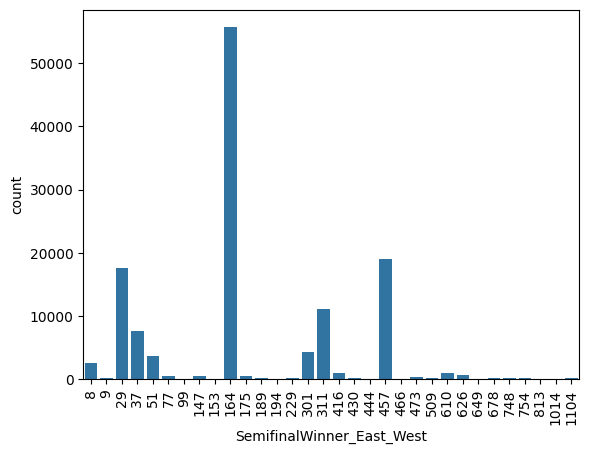

In [95]:
ax_1 = ax_1 = sns.countplot(x=model_1_df['SemifinalWinner_East_West'])
plt.xticks(rotation=90)
plt.show()

In [99]:
dma_distribution_east_west = classic2_df.groupby(by =['CustomerDMACode', 'CustomerDMADescription'])['SemifinalWinner_East_West'] \
                                             .value_counts() \
                                             .unstack(fill_value=0)

dma_distribution_east_west_prop = dma_distribution_east_west.div(dma_distribution_east_west.sum(axis=1), axis=0)


dma_ew = dma_distribution_east_west_prop.loc[:, [29,311,457,164]]
dma_ew['sum'] = dma_ew[29] + dma_ew[311] + dma_ew[457] + dma_ew[164]

dma_ew

,SemifinalWinner_East_West,29,311,457,164,sum
CustomerDMACode,CustomerDMADescription,,,,,
500.0,PORTLAND - AUBURN,0.113281,0.078125,0.167969,0.500000,0.859375
501.0,NEW YORK,0.118680,0.068124,0.148351,0.484287,0.819442
502.0,BINGHAMTON,0.212963,0.055556,0.138889,0.388889,0.796296
503.0,MACON,0.063492,0.047619,0.222222,0.412698,0.746032
504.0,PHILADELPHIA,0.133038,0.072062,0.168884,0.422395,0.796378
...,...,...,...,...,...,...
855.0,SANTABARBRA - SANMAR - SANLUOB,0.129032,0.075269,0.096774,0.537634,0.838710
862.0,SACRAMNTO - STKTN - MODESTO,0.146648,0.076816,0.148045,0.427374,0.798883
866.0,FRESNO - VISALIA,0.143791,0.111111,0.163399,0.431373,0.849673


In [101]:
dma_ew['sum'].mean()

np.float64(0.7965361293158172)

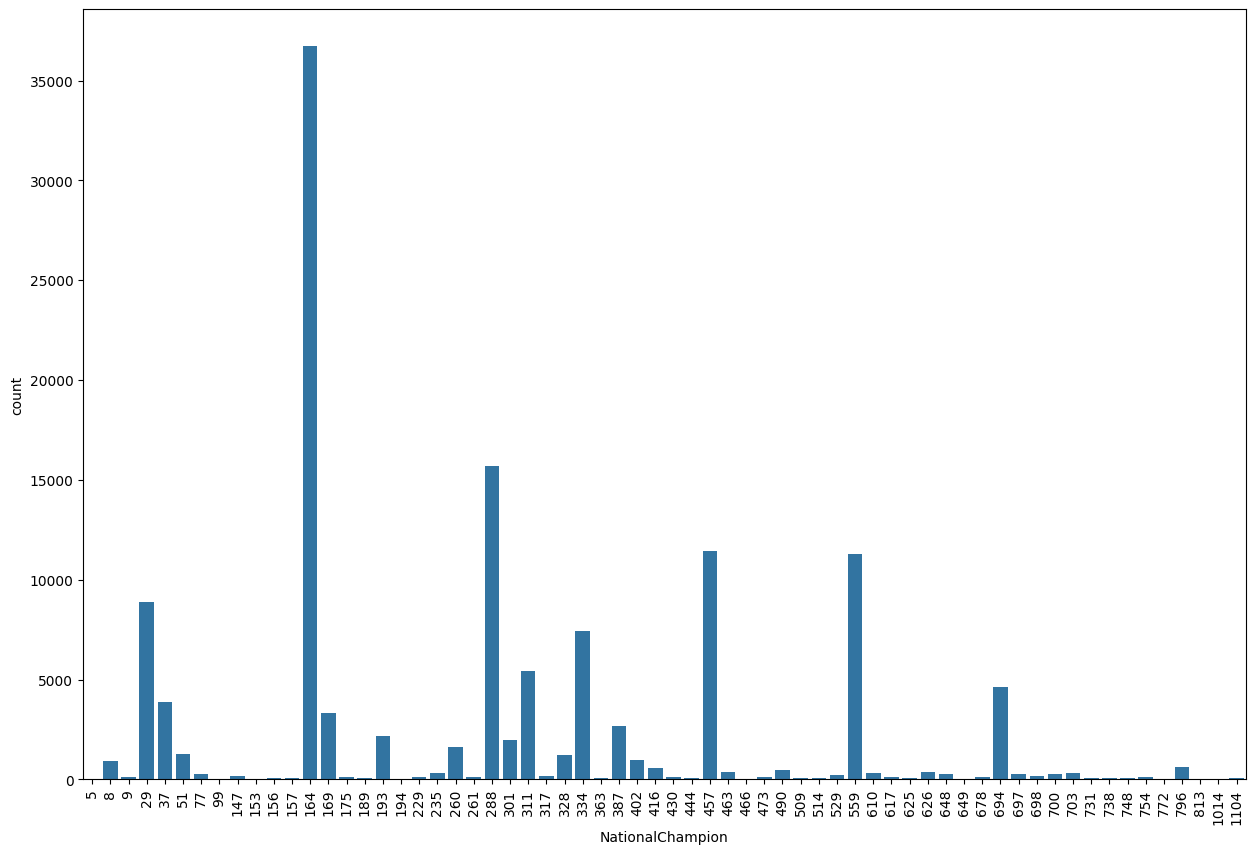

In [103]:
plt.figure(figsize=(15,10))
ax_1 = ax_1 = sns.countplot(x=model_1_df['NationalChampion'])
plt.xticks(rotation=90)
plt.show()